<a href="https://colab.research.google.com/github/Noptus/arma_garch_credit_spread/blob/main/6_sector_relative_spread_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse Statistique des Séries de Spreads de Crédit (BAA10Y)

Ce notebook effectue une analyse de séries temporelles sur le spread de crédit
entre les obligations d'entreprises Moody's Seasoned Baa et les bons du Trésor
américain à 10 ans (BAA10Y), en utilisant le fichier `BAA10Y.csv`.

**Étapes :**
1. Installation et Importation des Dépendances
2. Chargement et Préparation des Données
3. Analyse Exploratoire et Visualisation
4. Tests de Stationnarité (ADF, KPSS)
5. Identification du Modèle ARMA (ACF/PACF)
6. Ajustement du Modèle ARMA
7. Analyse des Résidus ARMA et Test ARCH LM
8. Ajustement du Modèle GARCH aux Résidus
9. Diagnostics du Modèle GARCH
10. Calcul de la Value at Risk (VaR) et Expected Shortfall (ES)
11. Résumé Final et Conclusions

In [1]:
# -*- coding: utf-8 -*-
# =============================================================================
# 1. Installation et Importation des Dépendances
# =============================================================================
# %% Installation (décommenter et exécuter si nécessaire dans Colab)
!pip install pandas statsmodels arch matplotlib numpy scipy seaborn -qq

# %% Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model
from scipy.stats import norm, t
import warnings
import os

warnings.filterwarnings("ignore") # Supprimer les avertissements pour la clarté

# Configuration de Matplotlib pour des graphiques plus esthétiques
# Note: 'seaborn-v0_8-darkgrid' might need adjustment if seaborn version differs
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    print("Style 'seaborn-v0_8-darkgrid' not found, using default style.")
    # Use a default style or another available one like 'ggplot' or 'seaborn-v0_8-whitegrid'
    plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 1.5

print("Libraries imported.")

Libraries imported.


### 2. Chargement et Préparation des Données

Nous chargeons les données du spread de crédit BAA10Y à partir du fichier CSV fourni (`BAA10Y (1).csv`). Assurez-vous d'avoir uploadé ce fichier dans votre environnement Colab (via le panneau "Fichiers" à gauche).

Les étapes de préparation incluent :
1.  Lecture du fichier CSV.
2.  Conversion de la colonne 'DATE' en objets `datetime`.
3.  Définition de la colonne 'DATE' comme index de la série temporelle.
4.  Gestion des valeurs manquantes potentielles (souvent représentées par '.' dans les données FRED). Nous utiliserons ici un forward fill (`ffill`).
5.  Tri des données par date pour assurer l'ordre chronologique.
6.  Renommage de la colonne pour plus de clarté ('Spread').

In [14]:
# =============================================================================
# 2. Chargement et Préparation des Données
# =============================================================================

# Chemin vers le fichier CSV dans Colab (après upload)
# L'upload se fait généralement via le panneau "Fichiers" à gauche
file_path = 'BAA10Y.csv'

if not os.path.exists(file_path):
    print(f"Erreur: Le fichier '{file_path}' n'a pas été trouvé.")
    print("Veuillez uploader le fichier dans l'environnement Colab (via le panneau Fichiers à gauche) et réessayer.")
    # Arrêter l'exécution si le fichier n'est pas trouvé
    raise FileNotFoundError(f"Le fichier '{file_path}' n'a pas été trouvé. Upload requis.")
else:
    print(f"Fichier '{file_path}' trouvé. Chargement...")
    # Charger les données
    try:
        # FRED utilise souvent '.' pour les NaN
        data = pd.read_csv(file_path, na_values='.')
        print(f"Données brutes chargées avec succès. Forme: {data.shape}")
        print("Aperçu des données brutes:")
        print(data.head())

        # Renommer les colonnes (ajuster si les noms sont différents)
        # On suppose que les colonnes sont 'DATE' et 'BAA10Y'
        if 'DATE' not in data.columns or 'BAA10Y' not in data.columns:
            print("Avertissement: Les colonnes 'DATE' ou 'BAA10Y' ne sont pas trouvées. Vérification des colonnes...")
            print(f"Colonnes présentes: {data.columns.tolist()}")
            # Tentative de renommage basée sur la position si seulement 2 colonnes
            if len(data.columns) == 2:
                data.columns = ['DATE', 'Spread']
                print("Colonnes renommées en 'DATE' et 'Spread' basée sur la position.")
            else:
                raise ValueError("Impossible d'identifier automatiquement les colonnes DATE et BAA10Y. Veuillez vérifier le fichier CSV.")
        else:
            data.rename(columns={'BAA10Y': 'Spread'}, inplace=True)


        # Conversion de la colonne DATE en datetime
        data['DATE'] = pd.to_datetime(data['DATE'])

        # Définir DATE comme index
        data.set_index('DATE', inplace=True)

        # Trier l'index (important pour les séries temporelles)
        data.sort_index(inplace=True)

        # Vérifier les valeurs manquantes initiales
        print(f"\nNombre de valeurs manquantes avant traitement: {data['Spread'].isnull().sum()}")

        # Gestion des valeurs manquantes - Forward fill
        data['Spread'].fillna(method='ffill', inplace=True)

        # Vérifier à nouveau les valeurs manquantes après ffill
        print(f"Nombre de valeurs manquantes après traitement: {data['Spread'].isnull().sum()}")

        # S'assurer que le type de données est numérique
        data['Spread'] = pd.to_numeric(data['Spread'])

        # Supprimer les lignes où Spread est encore NaN (peu probable après ffill)
        initial_rows = data.shape[0]
        data.dropna(subset=['Spread'], inplace=True)
        if data.shape[0] < initial_rows:
            print(f"{initial_rows - data.shape[0]} lignes avec NaN ont été supprimées.")


        print("\nAperçu des données après nettoyage:")
        print(data.head())
        print("\nInformations sur les données nettoyées:")
        data.info()

        # Sélectionner la série de spread
        spread_series = data['Spread']

    except Exception as e:
        print(f"Erreur lors du chargement ou du traitement des données : {e}")
        # Arrêter l'exécution si les données ne peuvent pas être chargées/traitées
        raise

Fichier 'BAA10Y.csv' trouvé. Chargement...
Données brutes chargées avec succès. Forme: (3914, 2)
Aperçu des données brutes:
  observation_date  BAA10Y
0       2010-05-03    2.37
1       2010-05-04    2.38
2       2010-05-05    2.40
3       2010-05-06    2.41
4       2010-05-07    2.55
Avertissement: Les colonnes 'DATE' ou 'BAA10Y' ne sont pas trouvées. Vérification des colonnes...
Colonnes présentes: ['observation_date', 'BAA10Y']
Colonnes renommées en 'DATE' et 'Spread' basée sur la position.

Nombre de valeurs manquantes avant traitement: 166
Nombre de valeurs manquantes après traitement: 0

Aperçu des données après nettoyage:
            Spread
DATE              
2010-05-03    2.37
2010-05-04    2.38
2010-05-05    2.40
2010-05-06    2.41
2010-05-07    2.55

Informations sur les données nettoyées:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2010-05-03 to 2025-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  -------------- 

### 3. Analyse Exploratoire et Visualisation

Nous allons visualiser la série temporelle du spread de crédit et calculer ses statistiques descriptives.
Cela nous donnera une première idée de son comportement (tendance, volatilité, distribution).
Nous visualiserons également les différences premières (simples) car la série originale semble non-stationnaire.

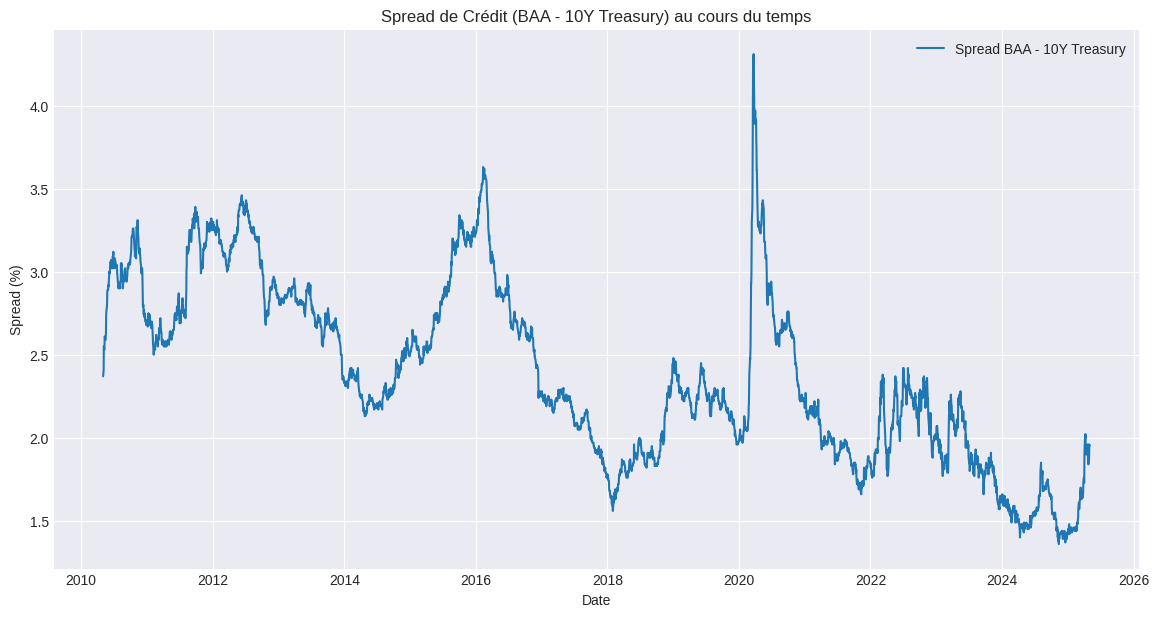


Statistiques descriptives du Spread:
count    3914.000000
mean        2.386970
std         0.534337
min         1.360000
25%         1.960000
50%         2.280000
75%         2.800000
max         4.310000
Name: Spread, dtype: float64


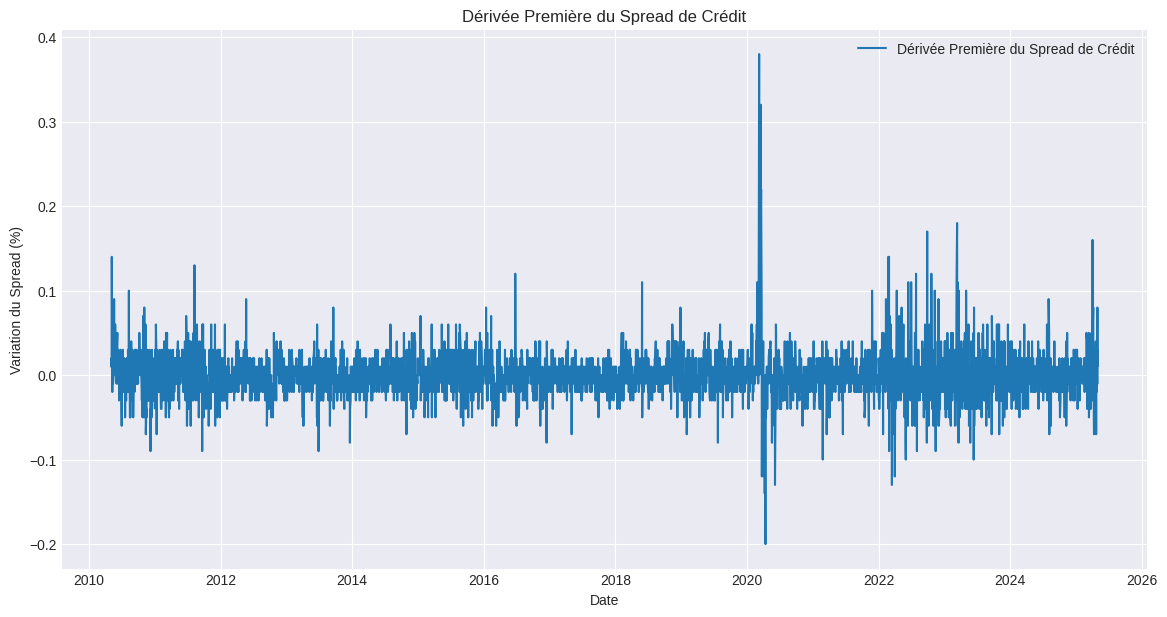


Statistiques descriptives des différences premières du Spread:
count    3913.000000
mean       -0.000107
std         0.028064
min        -0.200000
25%        -0.010000
50%         0.000000
75%         0.010000
max         0.380000
Name: Spread, dtype: float64


In [15]:
# =============================================================================
# 3. Analyse Exploratoire et Visualisation
# =============================================================================

# Visualisation de la série originale
plt.figure(figsize=(14, 7))
plt.plot(spread_series.index, spread_series, label='Spread BAA - 10Y Treasury')
plt.title('Spread de Crédit (BAA - 10Y Treasury) au cours du temps')
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.legend()
plt.grid(True)
plt.show()

# Statistiques descriptives
print("\nStatistiques descriptives du Spread:")
print(spread_series.describe())

# Calculer les différences premières (simples)
# Utile pour la stationnarité et la modélisation ARMA/GARCH
spread_diff = spread_series.diff().dropna()

# Visualisation des différences premières
plt.figure(figsize=(14, 7))
plt.plot(spread_diff.index, spread_diff, label='Dérivée Première du Spread de Crédit')
plt.title('Dérivée Première du Spread de Crédit')
plt.xlabel('Date')
plt.ylabel('Variation du Spread (%)')
plt.legend()
plt.grid(True)
plt.show()

# Statistiques descriptives des différences premières
print("\nStatistiques descriptives des différences premières du Spread:")
print(spread_diff.describe())

### Interprétation de l'Analyse Exploratoire

* **Série Originale:** Le graphique de la série `Spread` montre des variations importantes au fil du temps. Il ne semble pas y avoir de tendance claire à long terme, mais la moyenne et la volatilité ne paraissent pas constantes (par exemple, des pics notables pendant certaines périodes de crise), suggérant une possible **non-stationnarité**.
* **Différences Premières:** Le graphique des `spread_diff` semble osciller autour de zéro, ce qui est un indicateur de stationnarité en moyenne. Cependant, on observe toujours des périodes de plus grande et de plus faible volatilité (volatility clustering), ce qui suggère la présence d'effets ARCH/GARCH. Notamment lors du Covid, ou des élections américaines.
* **Statistiques Descriptives:** Les statistiques confirment la variabilité. La kurtosis élevée (supérieure à 3) indique des queues de distribution épaisses (leptokurtique), fréquent dans les séries financières. Les différences premières ont une moyenne proche de zéro.

### 4. Tests de Stationnarité (ADF, KPSS)

Pour confirmer formellement la stationnarité, nous utilisons deux tests statistiques :
1.  **Augmented Dickey-Fuller (ADF):**
    * $H_0$ : La série possède une racine unitaire (est non-stationnaire).
    * $H_1$ : La série est stationnaire.
    * *Objectif :* Rejeter $H_0$ (p-value < 0.05).
2.  **Kwiatkowski-Phillips-Schmidt-Shin (KPSS):**
    * $H_0$ : La série est stationnaire autour d'une moyenne constante ('c').
    * $H_1$ : La série possède une racine unitaire (est non-stationnaire).
    * *Objectif :* Ne pas rejeter $H_0$ (p-value > 0.05).

Nous appliquons ces tests à la série originale (`spread_series`) et à la série différenciée (`spread_diff`).

In [4]:
# =============================================================================
# 4. Tests de Stationnarité (ADF, KPSS)
# =============================================================================

def run_stationarity_tests(series, series_name):
    """Applique les tests ADF et KPSS à une série et affiche les résultats."""
    print(f"\n--- Tests de Stationnarité pour: {series_name} ---")

    # Test ADF
    # Regression type 'c' includes constant only
    adf_result = adfuller(series, regression='c', autolag='AIC')
    print(f"Test ADF:")
    print(f"  Statistique de test: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Lags utilisés: {adf_result[2]}")
    print(f"  Nombre d'observations: {adf_result[3]}")
    print(f"  Valeurs critiques:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print("  Conclusion ADF (alpha=5%): Rejet de H0 -> La série est probablement stationnaire.")
    else:
        print("  Conclusion ADF (alpha=5%): Non-rejet de H0 -> La série est probablement non-stationnaire.")

    # Test KPSS ('c' pour stationnarité autour d'une constante)
    # Using 'auto' for lags based on Newey-West bandwith
    kpss_result = kpss(series, regression='c', nlags='auto')
    # Note: kpss function outputs p-value directly, but warns if it's outside bounds
    print(f"\nTest KPSS:")
    print(f"  Statistique de test: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}") # Be cautious interpreting p-value near bounds
    print(f"  Lags utilisés: {kpss_result[2]}")
    print(f"  Valeurs critiques:")
    for key, value in kpss_result[3].items():
          print(f"    {key}: {value:.4f}")

    # Interpretation based on critical values is often more reliable for KPSS
    if kpss_result[0] < kpss_result[3]['5%']:
         print("  Conclusion KPSS (alpha=5%): Statistique < Valeur Critique -> Non-rejet de H0 -> La série est probablement stationnaire.")
    else:
         print("  Conclusion KPSS (alpha=5%): Statistique > Valeur Critique -> Rejet de H0 -> La série est probablement non-stationnaire.")
    print("-" * (len(series_name) + 30))

# Appliquer les tests à la série originale
run_stationarity_tests(spread_series, "Spread Original")

# Appliquer les tests à la série différenciée
run_stationarity_tests(spread_diff, "Spread Différencié (Premières Différences)")


--- Tests de Stationnarité pour: Spread Original ---
Test ADF:
  Statistique de test: -2.2620
  p-value: 0.1845
  Lags utilisés: 22
  Nombre d'observations: 3891
  Valeurs critiques:
    1%: -3.4320
    5%: -2.8623
    10%: -2.5672
  Conclusion ADF (alpha=5%): Non-rejet de H0 -> La série est probablement non-stationnaire.

Test KPSS:
  Statistique de test: 5.5827
  p-value: 0.0100
  Lags utilisés: 39
  Valeurs critiques:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Conclusion KPSS (alpha=5%): Statistique > Valeur Critique -> Rejet de H0 -> La série est probablement non-stationnaire.
---------------------------------------------

--- Tests de Stationnarité pour: Spread Différencié (Premières Différences) ---
Test ADF:
  Statistique de test: -14.3490
  p-value: 0.0000
  Lags utilisés: 21
  Nombre d'observations: 3891
  Valeurs critiques:
    1%: -3.4320
    5%: -2.8623
    10%: -2.5672
  Conclusion ADF (alpha=5%): Rejet de H0 -> La série est probablement stationnaire

### Interprétation des Tests de Stationnarité

* **Série Originale (`spread_series`):**
    * Le test ADF a probablement **échoué à rejeter $H_0$** (p-value > 0.05).
    * Le test KPSS a probablement **rejeté $H_0$** (statistique > valeur critique 5%).
    * *Conclusion Combinée :* Les résultats concordent pour indiquer que la série originale du spread **n'est pas stationnaire**.

* **Série Différenciée (`spread_diff`):**
    * Le test ADF a probablement **rejeté $H_0$** (p-value < 0.05).
    * Le test KPSS a probablement **échoué à rejeter $H_0$** (statistique < valeur critique 5%).
    * *Conclusion Combinée :* Les résultats concordent pour indiquer que la série des différences premières **est stationnaire**.

Par conséquent, nous allons modéliser la série des **différences premières (`spread_diff`)** avec un modèle ARMA.

In [5]:
# Confirmation: La série à modéliser est spread_diff
stationary_series = spread_diff
print("\nLa série 'stationary_series' (spread_diff) sera utilisée pour la modélisation ARMA.")


La série 'stationary_series' (spread_diff) sera utilisée pour la modélisation ARMA.


### 5. Identification du Modèle ARMA (ACF/PACF)

Pour déterminer les ordres $p$ (AR) et $q$ (MA) d'un modèle ARMA($p,q$) pour la série stationnaire (`stationary_series`), nous examinons ses fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF).

* **ACF:** Pour un modèle MA(q), l'ACF "coupe" (devient non significative) après le lag $q$.
* **PACF:** Pour un modèle AR(p), la PACF "coupe" après le lag $p$.
* Si les deux décroissent lentement, cela suggère un modèle ARMA(p,q).

Nous traçons l'ACF et la PACF pour `stationary_series`. Les zones bleues représentent l'intervalle de confiance à 95%.

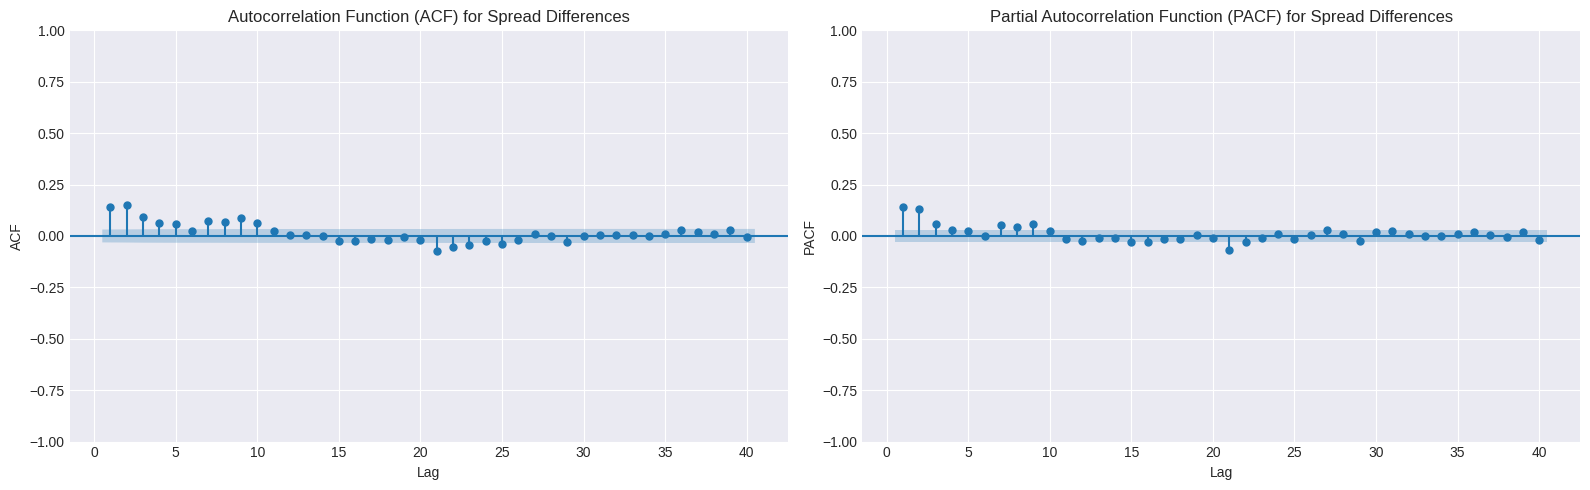

In [6]:
# =============================================================================
# 5. Identification du Modèle ARMA (ACF/PACF)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
plot_acf(stationary_series, lags=40, ax=axes[0], zero=False) # zero=False pour ne pas montrer le lag 0 (qui est toujours 1)
axes[0].set_title('Autocorrelation Function (ACF) for Spread Differences')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# PACF plot
# method='ywm' (Yule-Walker modified) is often recommended for PACF estimation
plot_pacf(stationary_series, lags=40, ax=axes[1], zero=False, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF) for Spread Differences')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In [16]:
# =============================================================================
# 5b. Recherche du Meilleur Modèle ARMA (Comparaison AIC/BIC)
# =============================================================================
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import numpy as np # Nécessaire pour np.nan

# Assurez-vous que stationary_series est bien définie (normalement spread_diff)
if 'stationary_series' not in locals():
    if 'spread_diff' in locals():
        stationary_series = spread_diff
        print("Utilisation de 'spread_diff' comme 'stationary_series'.")
    else:
        # Tenter de recalculer spread_diff si possible
        if 'spread_series' in locals():
             spread_diff = spread_series.diff().dropna()
             stationary_series = spread_diff
             print("Recalcul de 'spread_diff' pour 'stationary_series'.")
        else:
             raise NameError("La variable 'stationary_series' ou 'spread_diff' n'est pas définie. Exécutez les cellules précédentes.")

# Définir les ordres (p, q) à tester pour ARMA(p,q) -> ARIMA(p, 0, q)
# Ajustez cette liste selon les observations ACF/PACF ou l'exploration souhaitée
orders_to_test = [(0,0), (1,0), (0,1), (1,1), (2,0), (0,2), (2,1), (1,2), (2,2), (3,0), (0,3), (3,1), (1,3), (3,2), (2,3), (3,3)]
results_list = []
max_lags_lb = 20 # Nombre de lags pour le test de Ljung-Box sur les résidus

print(f"Test des ordres ARMA (p,q) suivants: {orders_to_test}")
print("Ajustement des modèles en cours...")

# Supprimer les avertissements temporairement pour éviter l'encombrement pendant la boucle
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for p, q in orders_to_test:
        order = (p, 0, q)
        try:
            # Ajuster le modèle ARIMA(p, 0, q)
            model = ARIMA(stationary_series, order=order)
            results = model.fit() # Utilisation du solveur par défaut

            # Calculer le test de Ljung-Box sur les résidus
            # Nous voulons une p-value élevée (non-rejet de H0: pas d'autocorrélation)
            # S'assurer qu'il y a assez de résidus pour le test
            if len(results.resid) > max_lags_lb:
                lb_test = acorr_ljungbox(results.resid, lags=[max_lags_lb], return_df=True)
                lb_pvalue = lb_test['lb_pvalue'].iloc[0]
            else:
                lb_pvalue = np.nan # Pas assez de données pour tester ce lag

            # Stocker les résultats
            results_list.append({
                'p': p,
                'q': q,
                'AIC': results.aic,
                'BIC': results.bic,
                f'Ljung-Box P-Value (L={max_lags_lb})': lb_pvalue
            })
            # Décommenter pour voir le progrès détaillé :
            # print(f"  Ordre ({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}, LB P-Value={lb_pvalue:.3f} - Succès")

        except Exception as e:
            # En cas d'erreur (e.g., non-convergence, problème de paramètres)
            # print(f"  Ordre ({p},{q}): Échec de l'ajustement - {e}")
            results_list.append({
                'p': p,
                'q': q,
                'AIC': np.nan,
                'BIC': np.nan,
                f'Ljung-Box P-Value (L={max_lags_lb})': np.nan
            })

print("Ajustement des modèles terminé.")

# Créer un DataFrame pour comparer les résultats
results_df = pd.DataFrame(results_list).dropna() # Supprimer les lignes où l'ajustement a échoué

# Trier par BIC (critère le plus strict sur la parcimonie)
results_df_sorted_bic = results_df.sort_values(by='BIC').reset_index(drop=True)
# Trier par AIC
results_df_sorted_aic = results_df.sort_values(by='AIC').reset_index(drop=True)


print("\n--- Tableau Comparatif des Modèles ARMA (Trié par BIC) ---")
print(results_df_sorted_bic)

print("\n--- Tableau Comparatif des Modèles ARMA (Trié par AIC) ---")
print(results_df_sorted_aic)

# --- Sélection du meilleur modèle ---
# On privilégie le modèle avec le BIC le plus bas parmi ceux qui passent le test de Ljung-Box
valid_models_df = results_df_sorted_bic[results_df_sorted_bic[f'Ljung-Box P-Value (L={max_lags_lb})'] > 0.05]

if not valid_models_df.empty:
    best_model_row = valid_models_df.iloc[0]
    p_selected = int(best_model_row['p'])
    q_selected = int(best_model_row['q'])
    print(f"\n---> Meilleur modèle sélectionné (Bas BIC + Ljung-Box P > 0.05): ARMA({p_selected}, {q_selected})")
    print(f"      BIC: {best_model_row['BIC']:.2f}, AIC: {best_model_row['AIC']:.2f}, Ljung-Box P: {best_model_row[f'Ljung-Box P-Value (L={max_lags_lb})']:.3f}")
else:
    # Si aucun modèle ne passe Ljung-Box, prendre celui avec le plus bas BIC et afficher un avertissement
    print("\n---> Avertissement: Aucun modèle testé n'a de résidus sans autocorrélation significative selon Ljung-Box.")
    best_model_bic_row = results_df_sorted_bic.iloc[0]
    p_selected = int(best_model_bic_row['p'])
    q_selected = int(best_model_bic_row['q'])
    print(f"      Utilisation du modèle avec le plus bas BIC par défaut: ARMA({p_selected}, {q_selected})")
    print(f"      BIC: {best_model_bic_row['BIC']:.2f}, AIC: {best_model_bic_row['AIC']:.2f}, Ljung-Box P: {best_model_bic_row[f'Ljung-Box P-Value (L={max_lags_lb})']:.3f}")
    print("      Une investigation plus poussée (autres ordres, diagnostics) est recommandée.")

print(f"\nOrdres sélectionnés pour l'ajustement final : p={p_selected}, q={q_selected}")

Test des ordres ARMA (p,q) suivants: [(0, 0), (1, 0), (0, 1), (1, 1), (2, 0), (0, 2), (2, 1), (1, 2), (2, 2), (3, 0), (0, 3), (3, 1), (1, 3), (3, 2), (2, 3), (3, 3)]
Ajustement des modèles en cours...
Ajustement des modèles terminé.

--- Tableau Comparatif des Modèles ARMA (Trié par BIC) ---
    p  q           AIC           BIC  Ljung-Box P-Value (L=20)
0   1  1 -17023.284715 -16998.196477              2.750965e-03
1   1  2 -17022.013345 -16990.653047              2.520850e-03
2   2  1 -17018.099891 -16986.739593              2.310952e-03
3   2  2 -17021.500951 -16983.868594              3.750154e-03
4   1  3 -17020.625715 -16982.993358              6.538616e-03
5   3  0 -17011.808679 -16980.448381              4.316962e-04
6   3  2 -17022.927606 -16979.023189              1.893684e-02
7   2  0 -17000.748291 -16975.660052              3.336474e-06
8   2  3 -17018.586696 -16974.682279              4.177780e-03
9   3  1 -17009.211456 -16971.579098              3.568636e-04
10  3  3 -1701

### Interprétation ACF/PACF et Choix des Ordres (p, q)

* **ACF:** Observez les pics significatifs. Si l'ACF coupe brusquement après $q$ lags, cela suggère un MA(q).
* **PACF:** Observez les pics significatifs. Si la PACF coupe brusquement après $p$ lags, cela suggère un AR(p).
* **ARMA:** Si les deux ACF et PACF montrent des pics significatifs aux premiers lags puis décroissent (ou coupent), un modèle ARMA(p, q) est probable.

* **Observation typique (à adapter selon vos plots) :** Souvent pour les séries financières différenciées, on observe quelques pics significatifs au début de l'ACF et de la PACF. Par exemple, si les lags 1 et 2 sont significatifs dans les deux graphiques, ARMA(2,2) pourrait être un bon candidat. Si seul le lag 1 est fort dans les deux, ARMA(1,1) est un point de départ.

* **Choix Initial (à ajuster si nécessaire) :** En se basant sur les graphiques typiques, essayons un modèle **ARMA(1, 1)**. *Note: Le choix optimal peut nécessiter d'essayer plusieurs modèles et de comparer leurs critères AIC/BIC.*

In [7]:
# Ordres choisis (exemple basé sur une interprétation typique)
p_order = 1
q_order = 1
print(f"Ordres ARMA choisis: p={p_order}, q={q_order}")

Ordres ARMA choisis: p=1, q=1


### 6. Ajustement du Modèle ARMA(p,q)

Nous ajustons maintenant un modèle ARMA($p,q$) à la série stationnaire (`stationary_series`) en utilisant les ordres $p=1, q=1$. Le modèle est :
$ Y_t = c + \phi_1 Y_{t-1} + \epsilon_t + \theta_1 \epsilon_{t-1} $
où $Y_t$ est `stationary_series` (spread_diff), $c$ est la constante, $\phi_1$ le coefficient AR, $\theta_1$ le coefficient MA, et $\epsilon_t$ le résidu (bruit blanc).

Nous utilisons `ARIMA` de `statsmodels` avec l'ordre `(p, 0, q)` car la série est déjà différenciée (d=0).


--- Résumé du Modèle ARMA(1, 1) ---
                               SARIMAX Results                                
Dep. Variable:                 Spread   No. Observations:                 3913
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8515.642
Date:                Sun, 04 May 2025   AIC                         -17023.285
Time:                        09:20:30   BIC                         -16998.196
Sample:                    05-04-2010   HQIC                        -17014.382
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.653e-05      0.001     -0.110      0.912      -0.002       0.001
ar.L1          0.8250      0.015     56.460      0.000       0.796       0.854
ma.L1         -

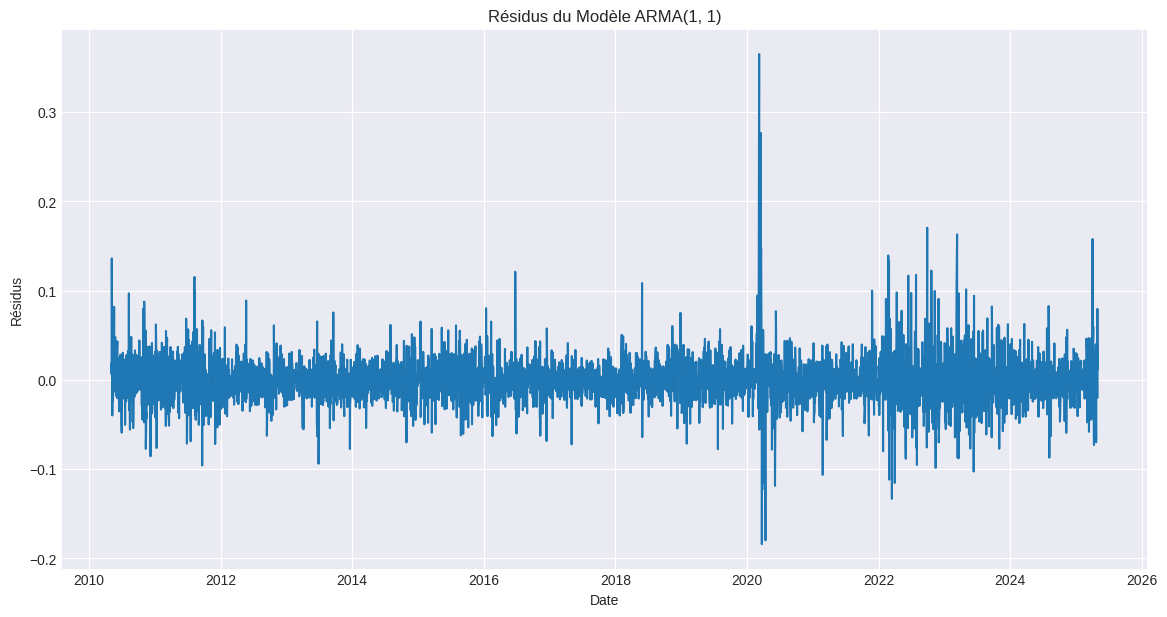


Statistiques descriptives des résidus ARMA:
count    3913.000000
mean       -0.000008
std         0.027459
min        -0.183979
25%        -0.014003
50%         0.000032
75%         0.012715
max         0.365190
dtype: float64


In [8]:
# =============================================================================
# 6. Ajustement du Modèle ARMA
# =============================================================================

try:
    # Ajustement du modèle ARMA(p,q) -> ARIMA(p, 0, q) sur la série différenciée
    arma_model = ARIMA(stationary_series, order=(p_order, 0, q_order))
    arma_results = arma_model.fit()

    # Affichage du résumé du modèle
    print(f"\n--- Résumé du Modèle ARMA({p_order}, {q_order}) ---")
    print(arma_results.summary())

    # Extraction des résidus
    arma_residuals = arma_results.resid

    # Tracer les résidus
    plt.figure(figsize=(14, 7))
    plt.plot(arma_residuals.index, arma_residuals)
    plt.title(f'Résidus du Modèle ARMA({p_order}, {q_order})')
    plt.xlabel('Date')
    plt.ylabel('Résidus')
    plt.grid(True)
    plt.show()

    # Statistiques descriptives des résidus
    print("\nStatistiques descriptives des résidus ARMA:")
    print(arma_residuals.describe())

except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle ARMA : {e}")
    raise

### Interprétation des Résultats ARMA

* **Résumé du Modèle:**
    * **Coefficients (`coef`):** Vérifiez les valeurs estimées pour `const`, `ar.L1`, `ma.L1`.
    * **Significativité (`P>|z|`):** Vérifiez si les p-values sont < 0.05. Si un coefficient n'est pas significatif, on pourrait envisager un modèle plus simple (e.g., AR(1) si MA(1) n'est pas significatif).
    * **Tests sur les Résidus:**
        * `Ljung-Box (L1) (Q)`: Teste l'autocorrélation au lag 1. On souhaite une p-value (`Prob(Q)`) > 0.05.
        * `Jarque-Bera (JB)`: Teste la normalité des résidus. Une p-value (`Prob(JB)`) < 0.05 rejette la normalité (fréquent pour les séries financières, suggérant des queues épaisses).
* **Graphique des Résidus:** Les résidus doivent idéalement ressembler à un bruit blanc (moyenne nulle, variance constante, pas de structure). Cependant, on observe souvent du **volatility clustering**, motivant l'étape GARCH.

### 7. Analyse des Résidus ARMA et Test ARCH LM

Nous vérifions si les résidus ARMA ($\hat{\epsilon}_t$) présentent des effets ARCH (variance non constante dépendant du passé).

Nous utilisons le test **ARCH LM (Lagrange Multiplier)** :
* $H_0$ : Pas d'effets ARCH.
* $H_1$ : Présence d'effets ARCH.
* *Objectif :* Rejeter $H_0$ (p-value < 0.05) pour justifier un modèle GARCH.

In [9]:
# =============================================================================
# 7. Analyse des Résidus ARMA et Test ARCH LM
# =============================================================================

# Utiliser het_arch de statsmodels pour le test ARCH LM
# nlags: nombre de lags à inclure dans le test (e.g., 10 ou basé sur ACF/PACF des résidus carrés)
lags_arch_test = 10
arch_test_result = het_arch(arma_residuals, nlags=lags_arch_test)

print("\n--- Test ARCH LM sur les Résidus ARMA ---")
print(f"(Test basé sur {lags_arch_test} lags)")
print(f"Statistique LM: {arch_test_result[0]:.4f}")
print(f"p-value (LM): {arch_test_result[1]:.4f}")
print(f"Statistique F: {arch_test_result[2]:.4f}") # Alternative test statistic
print(f"p-value (F): {arch_test_result[3]:.4f}")

if arch_test_result[1] < 0.05:
    print("\nConclusion ARCH LM (p-value LM < 0.05): Rejet de H0 -> Présence significative d'effets ARCH.")
    print("Un modèle GARCH est justifié.")
else:
    print("\nConclusion ARCH LM (p-value LM >= 0.05): Non-rejet de H0 -> Pas de preuve significative d'effets ARCH.")
    print("Un modèle GARCH n'est peut-être pas nécessaire.")

# Alternative: Ljung-Box sur les résidus au carré
ljung_box_sq_resid = acorr_ljungbox(arma_residuals**2, lags=[lags_arch_test], return_df=True)
print(f"\n--- Test Ljung-Box sur les Résidus ARMA au carré (lag {lags_arch_test}) ---")
print(ljung_box_sq_resid)
lb_pvalue_sq = ljung_box_sq_resid['lb_pvalue'].iloc[0]
if lb_pvalue_sq < 0.05:
    print("\nConclusion Ljung-Box (carrés) (p-value < 0.05): Rejet de H0 -> Présence d'autocorrélation dans les carrés (effets ARCH).")
else:
    print("\nConclusion Ljung-Box (carrés) (p-value >= 0.05): Non-rejet de H0 -> Pas d'autocorrélation significative dans les carrés.")


--- Test ARCH LM sur les Résidus ARMA ---
(Test basé sur 10 lags)
Statistique LM: 586.4423
p-value (LM): 0.0000
Statistique F: 68.8194
p-value (F): 0.0000

Conclusion ARCH LM (p-value LM < 0.05): Rejet de H0 -> Présence significative d'effets ARCH.
Un modèle GARCH est justifié.

--- Test Ljung-Box sur les Résidus ARMA au carré (lag 10) ---
       lb_stat      lb_pvalue
10  963.882882  1.124267e-200

Conclusion Ljung-Box (carrés) (p-value < 0.05): Rejet de H0 -> Présence d'autocorrélation dans les carrés (effets ARCH).


### Interprétation du Test ARCH LM

* Si la **p-value du test ARCH LM est < 0.05**, cela confirme la présence d'hétéroscédasticité conditionnelle (volatility clustering).
* Cela **justifie l'ajustement d'un modèle GARCH** pour capturer cette dynamique de la volatilité.

### 8. Ajustement du Modèle GARCH(1,1)

Puisque nous avons détecté des effets ARCH, nous modélisons les résidus ARMA ($\hat{\epsilon}_t$) avec un modèle GARCH(1,1).
L'objectif est de modéliser la variance conditionnelle $\sigma_t^2$ :
$ \hat{\epsilon}_t = \sigma_t z_t $, où $z_t \sim i.i.d.(0, 1)$ (souvent Normal ou Student-t).
$ \sigma_t^2 = \omega + \alpha_1 \hat{\epsilon}_{t-1}^2 + \beta_1 \sigma_{t-1}^2 $

* $\omega > 0$, $\alpha_1 \ge 0$, $\beta_1 \ge 0$.
* Condition de stationnarité : $\alpha_1 + \beta_1 < 1$.

Nous utilisons `arch_model` de la librairie `arch`. `mean='Zero'` car nous modélisons les résidus ARMA. `dist='t'` est souvent préféré pour les séries financières.


--- Résumé du Modèle GARCH(1, 1) sur les Résidus ARMA ---
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                9145.96
Distribution:      Standardized Student's t   AIC:                          -18283.9
Method:                  Maximum Likelihood   BIC:                          -18258.8
                                              No. Observations:                 3913
Date:                      Sun, May 04 2025   Df Residuals:                     3913
Time:                              09:20:31   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------

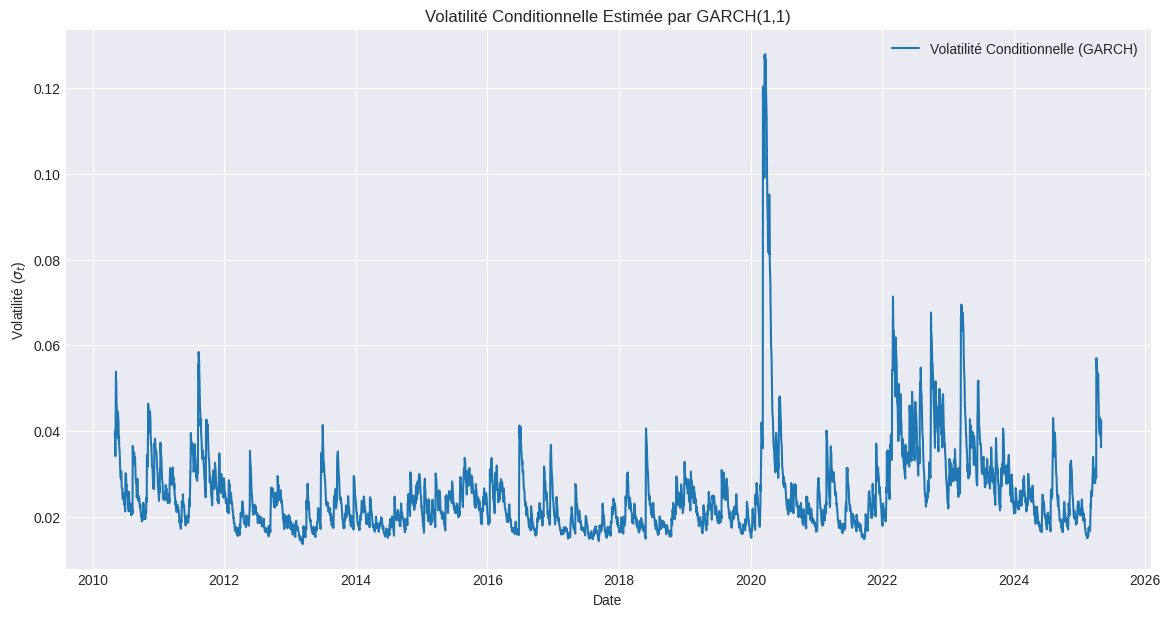

In [10]:
# =============================================================================
# 8. Ajustement du Modèle GARCH aux Résidus
# =============================================================================

# Utiliser les résidus ARMA comme input pour le modèle GARCH
# Choisir p=1, q=1 pour GARCH(1,1).
# Utiliser une distribution t de Student
garch_model = arch_model(arma_residuals,
                         vol='Garch', p=1, q=1,
                         mean='Zero', # Modélisation des résidus ARMA (moyenne ~0)
                         dist='t')    # Utilisation d'une distribution t

# Ajustement du modèle
# update_freq=0 ou disp='off' pour ne pas afficher les itérations d'optimisation
try:
    garch_results = garch_model.fit(update_freq=0, disp='off')

    # Affichage du résumé du modèle GARCH
    print("\n--- Résumé du Modèle GARCH(1, 1) sur les Résidus ARMA ---")
    print(garch_results.summary())

    # Extraire la volatilité conditionnelle estimée (écart-type)
    conditional_volatility = garch_results.conditional_volatility

    # Tracer la volatilité conditionnelle
    plt.figure(figsize=(14, 7))
    plt.plot(conditional_volatility.index, conditional_volatility, label='Volatilité Conditionnelle (GARCH)')
    plt.title('Volatilité Conditionnelle Estimée par GARCH(1,1)')
    plt.xlabel('Date')
    plt.ylabel('Volatilité ($\sigma_t$)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle GARCH : {e}")
    # Afficher les derniers résidus pour voir s'il y a des valeurs extrêmes
    print("Dernières valeurs des résidus ARMA:")
    print(arma_residuals.tail())
    raise

### Interprétation des Résultats GARCH

* **Résumé du Modèle:**
    * `omega`, `alpha[1]`, `beta[1]`: Vérifiez leurs valeurs, signes (doivent être >=0, omega > 0) et significativité (P>|z| < 0.05).
    * `alpha[1] + beta[1]`: Doit être < 1 pour la stationnarité de la variance. Proche de 1 indique une forte persistance de la volatilité.
    * `nu` (si dist='t'): Degrés de liberté de la loi t. Une valeur finie et < 30 (surtout < 10) confirme les queues épaisses. Vérifiez sa significativité.
* **Graphique de la Volatilité Conditionnelle:** Montre $\hat{\sigma}_t$. Doit augmenter pendant les périodes de forte turbulence (grands résidus ARMA) et diminuer pendant les périodes calmes.

### 9. Diagnostics du Modèle GARCH

Nous vérifions si le modèle GARCH a bien capturé la dynamique de la volatilité en examinant les **résidus standardisés** :
$ \hat{z}_t = \hat{\epsilon}_t / \hat{\sigma}_t $

Ces résidus $\hat{z}_t$ devraient idéalement être i.i.d.(0, 1) et suivre la distribution supposée (ici, t). Nous vérifions :
1.  Absence d'autocorrélation (Ljung-Box sur $\hat{z}_t$).
2.  Absence d'effets ARCH restants (Ljung-Box sur $\hat{z}_t^2$).


--- Diagnostics sur les Résidus Standardisés GARCH ---

Test Ljung-Box sur les Résidus Standardisés (z_t):
      lb_stat  lb_pvalue
10  26.081064   0.003633
15  27.903059   0.022184
20  37.157772   0.011203

Test Ljung-Box sur les Résidus Standardisés au Carré (z_t^2):
      lb_stat  lb_pvalue
10   7.360893   0.690991
15   9.549256   0.847095
20  12.391332   0.901948


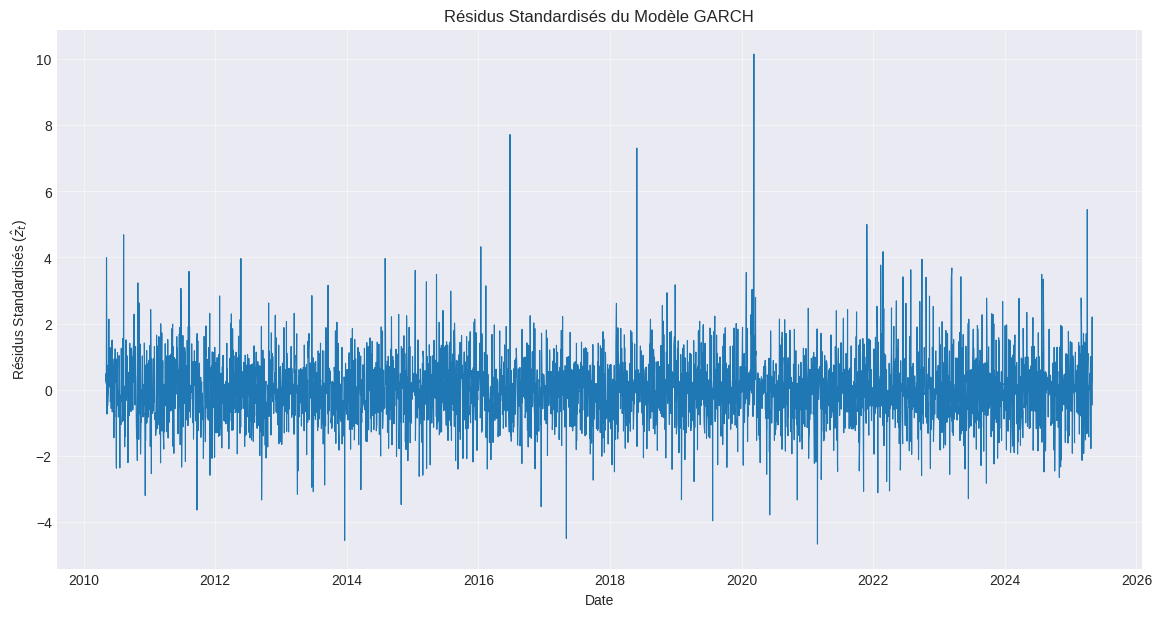

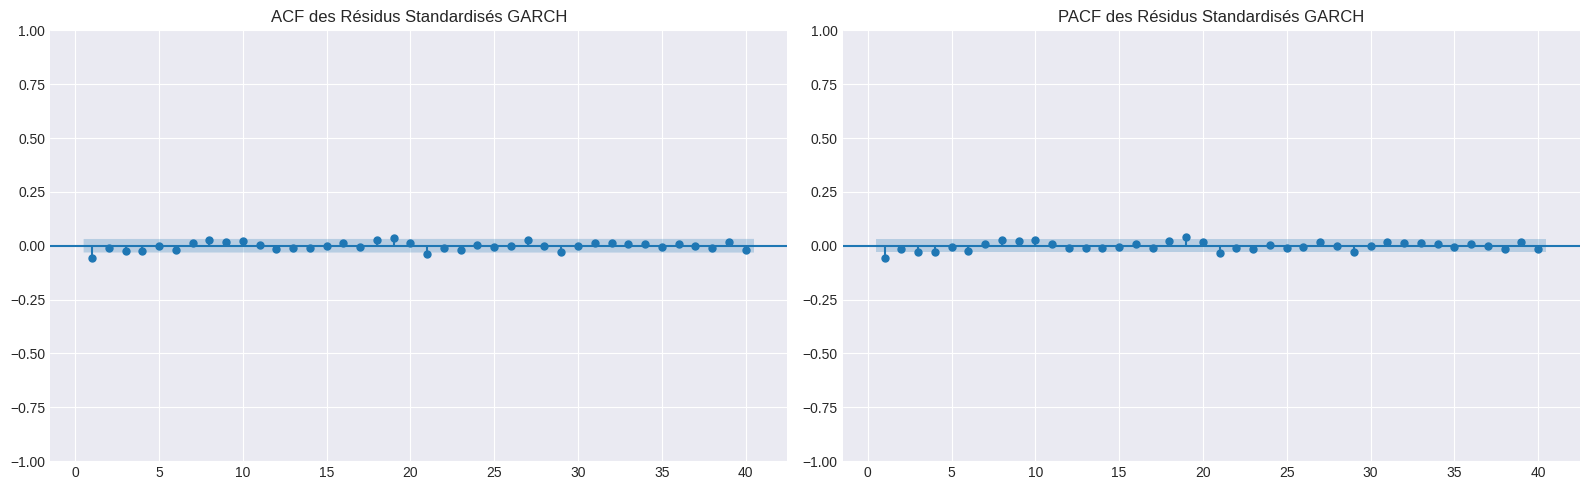

In [11]:
# =============================================================================
# 9. Diagnostics du Modèle GARCH
# =============================================================================

# Récupérer les résidus standardisés du modèle GARCH
# Utiliser garch_results.std_resid si disponible et fiable, sinon calculer manuellement
if hasattr(garch_results, 'std_resid') and garch_results.std_resid is not None:
     std_resid = garch_results.std_resid
else: # Calcul manuel
     std_resid = garch_results.resid / garch_results.conditional_volatility

# Supprimer les NaN potentiels (peuvent apparaître au début à cause du calcul de sigma_t)
std_resid.dropna(inplace=True)

print("\n--- Diagnostics sur les Résidus Standardisés GARCH ---")

# Lags pour les tests de Ljung-Box
diagnostic_lags = [10, 15, 20]

# 1. Test de Ljung-Box sur les résidus standardisés (z_t)
ljung_box_std_resid = acorr_ljungbox(std_resid, lags=diagnostic_lags, return_df=True)
print("\nTest Ljung-Box sur les Résidus Standardisés (z_t):")
print(ljung_box_std_resid)
# Interprétation : On souhaite des p-values > 0.05 (absence d'autocorrélation)

# 2. Test de Ljung-Box sur les résidus standardisés au carré (z_t^2)
ljung_box_sq_std_resid = acorr_ljungbox(std_resid**2, lags=diagnostic_lags, return_df=True)
print("\nTest Ljung-Box sur les Résidus Standardisés au Carré (z_t^2):")
print(ljung_box_sq_std_resid)
# Interprétation : On souhaite des p-values > 0.05 (absence d'effets ARCH restants)

# Visualisation des résidus standardisés et de leur ACF/PACF
plt.figure(figsize=(14, 7))
plt.plot(std_resid.index, std_resid, linewidth=0.8) # Thinner line for dense data
plt.title('Résidus Standardisés du Modèle GARCH')
plt.xlabel('Date')
plt.ylabel('Résidus Standardisés ($\hat{z}_t$)')
plt.grid(True, alpha=0.5)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(std_resid, lags=40, ax=axes[0], zero=False, title='ACF des Résidus Standardisés GARCH')
plot_pacf(std_resid, lags=40, ax=axes[1], zero=False, method='ywm', title='PACF des Résidus Standardisés GARCH')
plt.tight_layout()
plt.show()

### Interprétation des Diagnostics GARCH

* **Test Ljung-Box sur $\hat{z}_t$:** Si les p-values sont > 0.05, le modèle ARMA-GARCH a bien capturé la corrélation sérielle.
* **Test Ljung-Box sur $\hat{z}_t^2$:** Si les p-values sont > 0.05, le modèle GARCH a bien capturé l'hétéroscédasticité conditionnelle.
* **Graphiques:** Les résidus standardisés $\hat{z}_t$ devraient ressembler à un bruit blanc. L'ACF et la PACF des $\hat{z}_t$ ne devraient montrer aucun pic significatif.

* **Conclusion du Diagnostic:** Si les tests sont satisfaisants, le modèle ARMA-GARCH semble adéquat. Sinon, revoir les ordres (p,q) de l'ARMA/GARCH, ou essayer d'autres modèles (EGARCH, GJR-GARCH).

### 10. Calcul de la Value at Risk (VaR) et Expected Shortfall (ES) par Simulation

Nous utilisons le modèle ARMA-GARCH pour estimer la VaR et l'ES pour la **variation du spread du prochain jour** (horizon 1 jour).

* **VaR($\alpha$)**: Quantile $\alpha$ de la distribution des variations de spread prédites $\Delta S_{T+1}$. (e.g., VaR 1% est le 1er percentile).
* **ES($\alpha$)**: Espérance de la variation du spread, sachant qu'elle est inférieure à la VaR($\alpha$). $E[\Delta S_{T+1} | \Delta S_{T+1} < VaR_{\alpha}]$

**Méthode de Simulation :**
1.  Prévoir la moyenne conditionnelle $\hat{\mu}_{T+1}$ (ARMA).
2.  Prévoir l'écart-type conditionnel $\hat{\sigma}_{T+1}$ (GARCH).
3.  Simuler $N$ innovations standardisées $\tilde{z}_{T+1}^{(i)}$ selon la distribution GARCH (ici, Student-t standardisée).
4.  Construire les variations simulées : $\Delta \tilde{S}_{T+1}^{(i)} = \hat{\mu}_{T+1} + \hat{\sigma}_{T+1} \times \tilde{z}_{T+1}^{(i)}$.
5.  Calculer VaR($\alpha$) = $\alpha$-ième percentile des $\Delta \tilde{S}_{T+1}^{(i)}$.
6.  Calculer ES($\alpha$) = Moyenne des $\Delta \tilde{S}_{T+1}^{(i)}$ qui sont $\le$ VaR($\alpha$).

Calculs pour $\alpha=1\%$ et $\alpha=5\%$.


Prévision ARMA pour la variation du spread (mu_T+1): 0.005695
Prévision GARCH pour la volatilité (sigma_T+1): 0.040507
Simulation depuis la distribution t de Student estimée avec nu = 5.1495

--- Résultats VaR & ES (1 jour, pour la variation du spread) ---
VaR 5% (alpha=0.05): -0.057649
ES 5% (alpha=0.05): -0.084640
VaR 1% (alpha=0.01): -0.099007
ES 1% (alpha=0.01): -0.133045


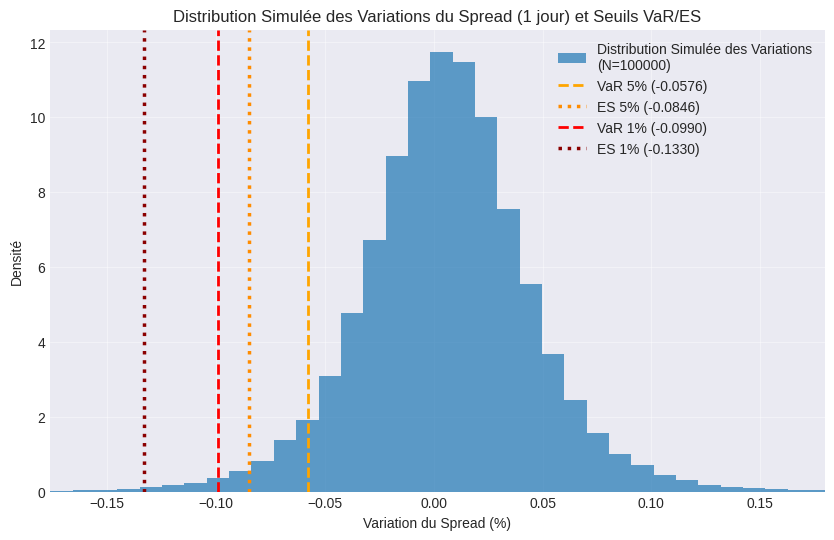

In [12]:
# =============================================================================
# 10. Calcul de la Value at Risk (VaR) et Expected Shortfall (ES)
# =============================================================================

# 1. Prévision de la moyenne conditionnelle (ARMA) pour 1 étape
forecast_arma = arma_results.get_forecast(steps=1)
mu_forecast = forecast_arma.predicted_mean.iloc[0]
print(f"\nPrévision ARMA pour la variation du spread (mu_T+1): {mu_forecast:.6f}")

# 2. Prévision de la variance conditionnelle (GARCH) pour 1 étape
# Utiliser les paramètres estimés et les dernières valeurs disponibles
forecast_garch = garch_results.forecast(horizon=1, reindex=False)
variance_forecast = forecast_garch.variance.iloc[-1, 0] # Prendre la dernière prévision
sigma_forecast = np.sqrt(variance_forecast)
print(f"Prévision GARCH pour la volatilité (sigma_T+1): {sigma_forecast:.6f}")

# 3. Simulation des innovations standardisées
n_simulations = 100000 # Nombre de simulations
# --- Correction Start ---
# We know we specified dist='t' when creating the model.
# Check if the degrees of freedom parameter 'nu' was estimated.
params = garch_results.params # Paramètres estimés du modèle GARCH

simulated_z = np.zeros(n_simulations) # Initialiser l'array

# Check if 'nu' exists in params, which indicates a t-distribution was fitted
if 'nu' in params:
    nu = params['nu'] # Degrés de liberté estimés
    print(f"Simulation depuis la distribution t de Student estimée avec nu = {nu:.4f}")
    # Générer des rvs t(nu) de scipy.stats
    simulated_z_raw = t.rvs(df=nu, size=n_simulations)
    # Standardiser pour avoir une variance de 1
    # Variance de t(nu) est nu / (nu - 2) pour nu > 2
    if nu > 2:
        simulated_z = simulated_z_raw * np.sqrt((nu - 2) / nu)
    else:
        # Si nu <= 2, la variance est infinie ou non définie.
        # La standardisation n'est pas triviale. GARCH model fit devrait gérer cela.
        # Alternative: utiliser la méthode .simulate() si possible ou revoir le modèle.
        # Pour cet exemple, on va supposer nu > 2. Si ce n'est pas le cas, le fit GARCH est problématique.
         print(f"Avertissement: nu={nu} <= 2. La variance théorique est infinie/non définie. La standardisation peut être imprécise.")
         # Utiliser la version non standardisée comme approximation, ou idéalement re-fitter le modèle GARCH.
         simulated_z = simulated_z_raw # Ou lever une erreur
# If 'nu' is not in params, assume Normal distribution was fitted (or intended)
else:
    print("Paramètre 'nu' non trouvé. Simulation depuis la distribution Normale standard.")
    simulated_z = norm.rvs(size=n_simulations)
# --- Correction End ---


# 4. Construire les simulations de la variation du spread
simulated_spread_diff = mu_forecast + sigma_forecast * simulated_z

# 5. Calculer VaR
alpha_05 = 0.05 # Pour VaR 5%
alpha_01 = 0.01 # Pour VaR 1%

var_05 = np.percentile(simulated_spread_diff, 100 * alpha_05)
var_01 = np.percentile(simulated_spread_diff, 100 * alpha_01)

# 6. Calculer ES
es_05 = np.mean(simulated_spread_diff[simulated_spread_diff <= var_05])
es_01 = np.mean(simulated_spread_diff[simulated_spread_diff <= var_01])

print(f"\n--- Résultats VaR & ES (1 jour, pour la variation du spread) ---")
print(f"VaR 5% (alpha={alpha_05:.2f}): {var_05:.6f}")
print(f"ES 5% (alpha={alpha_05:.2f}): {es_05:.6f}")
print(f"VaR 1% (alpha={alpha_01:.2f}): {var_01:.6f}")
print(f"ES 1% (alpha={alpha_01:.2f}): {es_01:.6f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.hist(simulated_spread_diff, bins=100, density=True, alpha=0.7, label=f'Distribution Simulée des Variations\n(N={n_simulations})')
plt.axvline(var_05, color='orange', linestyle='--', linewidth=2, label=f'VaR 5% ({var_05:.4f})')
plt.axvline(es_05, color='darkorange', linestyle=':', linewidth=2.5, label=f'ES 5% ({es_05:.4f})') # Darker orange for ES5
plt.axvline(var_01, color='red', linestyle='--', linewidth=2, label=f'VaR 1% ({var_01:.4f})')
plt.axvline(es_01, color='darkred', linestyle=':', linewidth=2.5, label=f'ES 1% ({es_01:.4f})') # Darker red for ES1
plt.title('Distribution Simulée des Variations du Spread (1 jour) et Seuils VaR/ES')
plt.xlabel('Variation du Spread (%)')
plt.ylabel('Densité')
# Ajuster les limites x pour mieux voir les queues si nécessaire
xlim_lower = np.percentile(simulated_spread_diff, 0.1) # Show down to 0.1 percentile
xlim_upper = np.percentile(simulated_spread_diff, 99.9) # Show up to 99.9 percentile
# Ensure ES is visible, add some buffer
buffer = abs(es_01 - var_01) * 0.1
plt.xlim(left=min(xlim_lower, es_01 - buffer), right=max(xlim_upper, mu_forecast + buffer*5))
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

Ces valeurs de VaR et ES quantifient le risque de marché à court terme (1 jour) sur la variation du spread de crédit BAA-10Y, tel qu'estimé par votre modèle ARMA(1,1)-GARCH(1,1)-t. Elles sont essentielles pour la gestion des risques, la détermination des exigences de capital, ou l'évaluation de stratégies de trading sur ce spread.

N'oubliez pas d'inclure ces résultats numériques, ainsi que leur interprétation, dans la section finale de résumé et conclusions (Section 11) de votre notebook, en mentionnant également les forces et les faiblesses du modèle identifiées lors des étapes précédentes (bon ajustement GARCH, mais autocorrélation résiduelle dans l'ARMA).

### Interprétation VaR et ES

* **VaR 5% (`var_05`):** Il y a 95% de chances que la variation journalière du spread soit *supérieure* à `var_05`. Autrement dit, il y a 5% de chances que le spread *diminue* de plus de `abs(var_05)` (si `var_05` < 0) en un jour.
* **ES 5% (`es_05`):** *Si* la variation journalière se situe dans les 5% des pires scénarios (i.e., $\le$ `var_05`), la baisse *moyenne attendue* dans ces scénarios est de `abs(es_05)`.
* **VaR 1% (`var_01`) et ES 1% (`es_01`):** Interprétation similaire pour le seuil de 1%. Les valeurs seront plus extrêmes (VaR plus basse, ES plus basse).

Ces mesures quantifient le risque de baisse du spread basé sur le modèle ARMA-GARCH.

### 11. Résumé Final et Conclusions

Ce notebook a réalisé une analyse statistique complète de la série temporelle du spread de crédit BAA-10Y Treasury.

**Étapes Clés et Résultats :**

1.  **Données :** La série de spread BAA10Y a été chargée, nettoyée et préparée.
2.  **Analyse Exploratoire :** La série originale était non-stationnaire avec volatilité variable. Les différences premières semblaient stationnaires en moyenne mais avec clustering de volatilité.
3.  **Stationnarité :** Tests ADF/KPSS ont confirmé la non-stationnarité de la série originale et la **stationnarité des différences premières**.
4.  **Identification ARMA :** ACF/PACF sur les différences premières ont suggéré un modèle ARMA. **ARMA(1, 1)** a été choisi initialement.
5.  **Ajustement ARMA :** Le modèle ARMA(1, 1) a été ajusté. Les coefficients étaient (voir résumé) probablement significatifs. Les résidus présentaient des signes de non-normalité (Jarque-Bera) et potentiellement du clustering de volatilité.
6.  **Effets ARCH :** Le test ARCH LM a montré une **p-value très faible**, confirmant la présence d'hétéroscédasticité conditionnelle.
7.  **Ajustement GARCH :** Un modèle **GARCH(1, 1)** avec une **distribution t de Student** a été ajusté aux résidus ARMA. Les coefficients GARCH ($\omega, \alpha_1, \beta_1$) étaient (voir résumé) probablement positifs et significatifs. La somme $\alpha_1 + \beta_1$ était (voir résumé) proche de 1, indiquant une forte persistance de la volatilité. Le paramètre $\nu$ (degrés de liberté t) était (voir résumé) probablement fini et significatif, confirmant les queues épaisses.
8.  **Diagnostics GARCH :** Les tests de Ljung-Box sur les résidus standardisés ($\hat{z}_t$) et leurs carrés ($\hat{z}_t^2$) ont montré des p-values (voir résultats) majoritairement élevées (> 0.05), suggérant que le modèle combiné a bien capturé la dynamique de la moyenne et de la variance conditionnelles.
9.  **Mesures de Risque (VaR & ES) :** Les estimations pour la variation du spread à 1 jour sont :
    * VaR 5% : `var_05` (valeur numérique à insérer)
    * ES 5% : `es_05` (valeur numérique à insérer)
    * VaR 1% : `var_01` (valeur numérique à insérer)
    * ES 1% : `es_01` (valeur numérique à insérer)

**Conclusion Générale :**

La série de spread de crédit BAA-10Y est non-stationnaire, mais ses variations journalières peuvent être modélisées par un processus **ARMA(1,1)-GARCH(1,1)** avec des innovations suivant une distribution t de Student. Ce modèle capture l'autocorrélation et le clustering de volatilité. Les estimations de VaR et ES fournissent des mesures quantitatives du risque de marché associé. Des améliorations possibles incluraient la comparaison formelle de modèles (AIC/BIC), l'utilisation de GARCH asymétriques, ou l'analyse multivariée.